In [1]:
import pickle 
import numpy as np

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec

from scipy import interpolate
from scipy.signal import savgol_filter
from scipy.stats import norm
import math
from collections.abc import Iterable
import random 
import matplotlib as mpl

SMALL_SIZE = 16
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

# Overall Font
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

mpl.rcParams['font.family'] = 'Arial'
# plt.rc('text', usetex=True)
# plt.rcParams['text.latex.preamble']=r"\boldmath"

%matplotlib widget
cm = 1/2.54 

with open('../../../moxie/data/processed/cleaned_pulse_dict_230522.pickle', 'rb') as file: 
    cleaned_dict = pickle.load(file)
with open('../../../moxie/data/processed/cleaned_ml_ready_dict_230522.pickle', 'rb') as file: 
    ml_dict = pickle.load(file)
with open('../../data/raw/new_elm_timings_catch.pickle', 'rb') as file: 
    JET_ELM_TIMINGS = pickle.load(file) 

In [356]:
# Get table for max, min values 
LABEL = ['Q95', 'RGEO', 'CR0', 'VOLM', 'TRIU', 'TRIL', 'ELON', 'POHM', 'IPLA', 'BVAC', 'NBI', 'ICRH', 'ELER']


ml_train_mps = ml_dict['train']['mps'][ml_dict['train']['mps'][:, -6] > 0]
ml_val_mps = ml_dict['val']['mps'][ml_dict['val']['mps'][:, -6] > 0]
ml_test_mps = ml_dict['test']['mps'][ml_dict['test']['mps'][:, -6] > 0]

max_train_mps, min_train_mps,  = np.max(ml_train_mps, 0), np.min(ml_train_mps, 0)
max_val_mps, min_val_mps  = np.max(ml_train_mps, 0), np.min(ml_train_mps, 0)
max_test_mps, min_test_mps = np.max(ml_test_mps, 0), np.min(ml_test_mps, 0)
min_mps, max_mps = np.min(np.vstack([min_train_mps, min_val_mps, min_test_mps]), 0), np.max(np.vstack([max_train_mps, max_val_mps, max_test_mps]), 0)

for lab, min_val, max_val, in zip(LABEL, min_mps, max_mps): 
    print(lab, min_val, max_val)


Q95 2.4046988 5.491099
RGEO 2.8057537 2.9729128
CR0 0.86744004 0.963695
VOLM 69.43909 80.07489
TRIU 0.08211198 0.46843666
TRIL 0.22676189 0.48135853
ELON 1.5895542 1.8283318
POHM 1015.88226 2270189.5
IPLA -3985944.0 -967057.0
BVAC -3.685322 -0.96262735
NBI 940262.25 32090660.0
ICRH -34.12134 7317709.0
ELER 0.0 1.3600583e+23


# Plot 0: A simple profile for the architecture figure



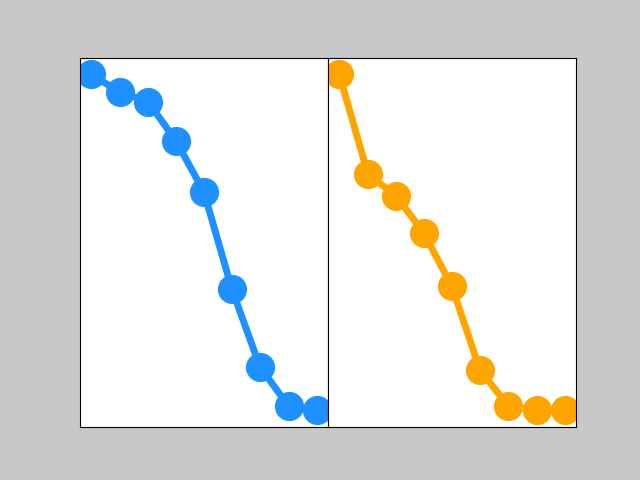

In [215]:
plt.close('all')
idx = 4000
profs, rmids, mask = ml_dict['train']['profiles'][idx], ml_dict['train']['rmids'][idx], ml_dict['train']['masks'][idx] > 0

fig, (n_ax, t_ax) = plt.subplots(1, 2, sharex=True) #, figsize=(2*cm, 6*cm)

n_ax.scatter(rmids[mask], profs[0][mask]*1e-19, color='dodgerblue', s=400)
n_ax.plot(rmids[mask], profs[0][mask]*1e-19, color='dodgerblue', lw=5)
t_ax.scatter(rmids[mask], profs[1][mask], color='orange', s=400)
t_ax.plot(rmids[mask], profs[1][mask], color='orange', lw=5)


n_ax.set_yticks([])
plt.yticks([])
plt.xticks([])
plt.subplots_adjust(wspace=0, hspace=0)
fig.patch.set_facecolor('#c8c8c8ff')
# fig.supxlabel('ELM % = 63', fontweight='bold', fontsize='xx-large', y=0.001)

plt.savefig('/home/kitadam/ENR_Sven/moxie/docs/source/poster/plot_for_arch.png', transparent=True)
plt.show()

## Plot 1: Show creating of dataset

#### $n_{e, sep}$ algorithm
- Find $r_{sep, prior} = \frac{1}{2}(r_{top} + r_{bot})$, where $r_{top}, r_{bot}$ are coordinates of electron density at the pedestal top and bottom respectively
- Find the first two points closest to $r_{sep, prior}$, $T_L$ and $T_R$ s.t. $T_R < 100 < T_L$
- Find $w_L, w_R$ for $T_{e, sep} = 100 \; [\text{eV}] = \frac{1}{2} (w_LT_L + w_RT_R)$
- Approximate $n_{e, sep} = \frac{1}{2} (w_Ln_L + w_Rn_R)$ for the density points $n_L, n_R$ corresponding to $T_L, T_R$

#### ELM Percentage

- Use ELM timings found in JET PDB
- $\text{ELM \%} = \frac{t_{\text{HRTS}} - t_{\text{Last ELM}}}{t_{\text{Next ELM}} - t_{\text{Last ELM}}}$ 

In [19]:
# print(cleaned_dict.keys())
#  '92288', '92306', '92313', '92314', '92315', '92316', '92319'
# cleaned_dict[str(92316)]['neseps'], cleaned_dict[str(92316)]['elm_perc']

In [13]:
# 81795, 81836, 81837


# relevant_pulse = cleaned_dict[str(92316)]
# pre_elm_idx, post_elm_idx = 15, 13# 5
# print(len(relevant_pulse['neseps']))
# post_elm = relevant_pulse['profiles'][post_elm_idx], relevant_pulse['rmids'][post_elm_idx], relevant_pulse['elm_perc'][post_elm_idx], relevant_pulse['mps'][post_elm_idx], relevant_pulse['rseps'][post_elm_idx], relevant_pulse['neseps'][post_elm_idx]
# pre_elm = relevant_pulse['profiles'][pre_elm_idx], relevant_pulse['rmids'][pre_elm_idx], relevant_pulse['elm_perc'][pre_elm_idx], relevant_pulse['mps'][pre_elm_idx], relevant_pulse['rseps'][pre_elm_idx], relevant_pulse['neseps'][pre_elm_idx]



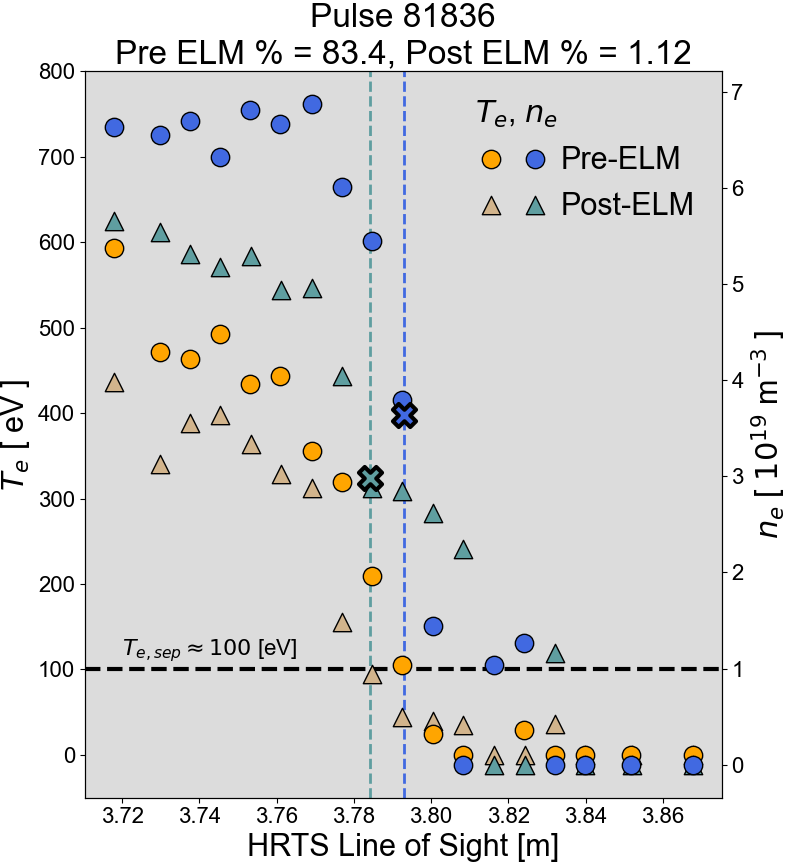

In [358]:
# for n, (ids, neseps, elms) in enumerate(zip(relevant_pulse['ids'],relevant_pulse['neseps'], relevant_pulse['elm_perc'])):
#     print(n, ids, neseps, elms)
    
# idx 23,24, ELM crash! 
relevant_pulse = cleaned_dict[str(81836)]
  
post_elm = relevant_pulse['profiles'][23], relevant_pulse['rmids'][23], relevant_pulse['elm_perc'][23], relevant_pulse['mps'][23], relevant_pulse['rseps'][23], relevant_pulse['neseps'][23]
pre_elm = relevant_pulse['profiles'][24], relevant_pulse['rmids'][24], relevant_pulse['elm_perc'][24], relevant_pulse['mps'][24], relevant_pulse['rseps'][24], relevant_pulse['neseps'][24]

plt.close('all')
fig, t_ax = plt.subplots(1, 1, constrained_layout=True, figsize=(20*cm, 22*cm))# , dpi=400)
t_ax.set_facecolor('gainsboro')
n_ax = t_ax.twinx()
point_size = 175

t_post_elm = t_ax.scatter(post_elm[1], post_elm[0][1], color='tan', edgecolor=(0, 0, 0), label='Post-', s=point_size, zorder=10, marker='^')
n_post_elm = n_ax.scatter(post_elm[1], post_elm[0][0]*1e-19, color='cadetblue', edgecolor=(0, 0, 0),s=point_size, label='Post ELM', zorder=10, marker='^')

n_pre_elm = n_ax.scatter(pre_elm[1], pre_elm[0][0]*1e-19, color='royalblue', edgecolor=(0, 0, 0), label='Pre ELM', s=point_size,  zorder=10, )
t_pre_elm = t_ax.scatter(pre_elm[1], pre_elm[0][1], color='orange', edgecolor=(0, 0, 0), label='Pre-', s=point_size, zorder=10, )



t_ax.axhline(100, color='black', ls='--', lw=3)# , label=r'$T_e\approx 100$ [eV]', lw=3)

t_ax.axvline(pre_elm[-2], color='royalblue', ls='--', zorder=0, lw=2)
t_ax.axvline(post_elm[-2], color='cadetblue', ls='--', zorder=0, lw=2)

n_ax.scatter(pre_elm[-2], pre_elm[-1]*1e-19, color='royalblue', edgecolor=(0, 0, 0), lw=3, s=275, marker='X',zorder=20, label='Pre-ELM $n_{e, sep}$')
n_ax.scatter(post_elm[-2], post_elm[-1]*1e-19, color='cadetblue', edgecolor=(0, 0, 0), lw=3,  s=275, marker='X', zorder=20, label='Post-ELM $n_{e, sep}$')

t_ax.set_ylabel('$T_e$ [ eV ]')
n_ax.set_ylabel('$n_e$ [ $10^{19}$ m$^{-3}$ ]')
t_ax.set_xlabel('HRTS Line of Sight [m]')

# Anotate the points T_L, T_R for pre-ELM
# t_ax.annotate('Pre-ELM $T_L$', xy=(3.792, 101), xytext=(-125, -40), textcoords='offset points', fontsize=SMALL_SIZE, 
#              arrowprops=dict(facecolor='black', shrink=0.05))
# t_ax.annotate('Pre-ELM $T_R$', xy=(3.799, 25), xytext=(-125, -20), textcoords='offset points', fontsize=SMALL_SIZE, 
#              arrowprops=dict(facecolor='black', shrink=0.05))

# Annotate TESEP 
t_ax.annotate(r'$T_{e, sep} \approx 100$ [eV]', xy=(3.72, 100), xytext=(0, 10), textcoords='offset points', fontsize=SMALL_SIZE)

from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

combined_legend = t_ax.legend([(t_pre_elm, n_pre_elm),(t_post_elm, n_post_elm)], ['Pre-ELM', 'Post-ELM'], handlelength=2.5,  handletextpad=0.3, handleheight=1,  handler_map={tuple: HandlerTuple(ndivide=None)}, title='$T_e$, $n_e$', title_fontsize=MEDIUM_SIZE, frameon=False,)
combined_legend._legend_box.align = "left"
t_ax.set_ylim(-50,800)

t_ax.set_title('Pulse {}\nPre ELM % = {:.3}, Post ELM % = 1.12'.format(81836, 100*pre_elm[2]))
# /home/kitadam/ENR_Sven/moxie/docs/source/poster/nesep_figure.png
plt.savefig('/home/kitadam/ENR_Sven/moxie/docs/source/poster/nesep_figure_revised.svg')
plt.show()

# Figure 2: Profile Prediction of VAE 

- 2 profiles, like the one above, taken from two different elm cycles
    - Test set
    - Same pulse, different elm cycles

In [324]:
ml_dict['test'].keys()
test_profs, test_neseps, test_ids, test_mps, test_elm_perc, _, test_rmids, test_masks, test_rseps = ml_dict['test'].values()
# 2, 7
start, end = 63, 98

# print(test_ids[start: end], test_neseps[start: end], test_elm_perc[start:end])
 
pre_elm_idx, post_elm_idx = 76, 68
# print('\nPostELM', test_ids[post_elm_idx], test_elm_perc[post_elm_idx], test_neseps[post_elm_idx])
# print('Pre ELM',test_ids[pre_elm_idx], test_elm_perc[pre_elm_idx], test_neseps[pre_elm_idx])
# print(test_ids[7], test_elm_perc[7], test_neseps[7])

In [95]:
def de_standardize(x, mu, var): 
    return (x*var) + mu

def standardize(x, mu, var): 
    return (x - mu) / var
def normalize_profiles(profiles, mu_T=None, var_T=None, mu_D=None, var_D=None): 
    if mu_D is not None and var_D is not None and mu_T is not None and var_T is not None: 
        profiles[:, 0] = standardize_simple(profiles[:, 0], mu_D, var_D)
        profiles[:, 1] = standardize_simple(profiles[:, 1], mu_T, var_T)
        return profiles 
    else:  
        profiles[:, 0], mu_D, var_D = standardize_simple(profiles[:, 0])
        profiles[:, 1], mu_T, var_T = standardize_simple(profiles[:, 1])
        return profiles, mu_D, var_D, mu_T, var_T
def standardize_simple(x, mu=None, var=None):
    if mu is not None and var is not None:
        x_normed = (x - mu ) / var
        return x_normed
    else:
        mu = x.mean(0, keepdim=True)[0]
        var = x.std(0, keepdim=True)[0]
        x_normed = (x - mu ) / var
        return x_normed, mu, var
    
from moxie.models.PSI_model_ak1 import PSI_MODEL
from moxie.data.profile_lightning_module import PLDATAMODULE_AK
from moxie.experiments.DIVA_EXP_AK_1 import EXAMPLE_DIVA_EXP_AK

import torch

# 'semi-supervised-start', 'semi-supervsied-cutoff', 'supervised'
model_hyperparams = {'out_length':19, 'elm_style_choice': 'simple',
                    'mach_latent_dim': 9, 'stoch_latent_dim': 3, # 0.0273
                    'beta_stoch': 2.0, 'beta_mach_unsup': 0.008,'beta_mach_sup':  0.00,
                    'alpha_mach': 1, 'alpha_prof': 500.0,  
                    'start_sup_time': 500,
                    'physics': True, 'gamma_stored_energy': 50.0, 'gamma_bpol': 5.0, 'gamma_beta': 0.0, 
                    'mp_hdims_aux': [64, 128, 128, 128], 'mp_hdims_cond':[64, 64, 32], 
                    'hidden_dims': [3, 6], 'loss_type': 'semi-supervised-cutoff-increasing',}

model = PSI_MODEL(**model_hyperparams)
state_dict_loc = '/home/kitadam/ENR_Sven/moxie/experiments/PSI_22/model_results/modelstatedict_PSI_v1.pth'
state_dict = torch.load(state_dict_loc)
model.load_state_dict(state_dict['model'])
MP_mu, MP_var = state_dict['MP_norms']
D_mu, D_var = state_dict['D_norms']
T_mu, T_var = state_dict['T_norms']


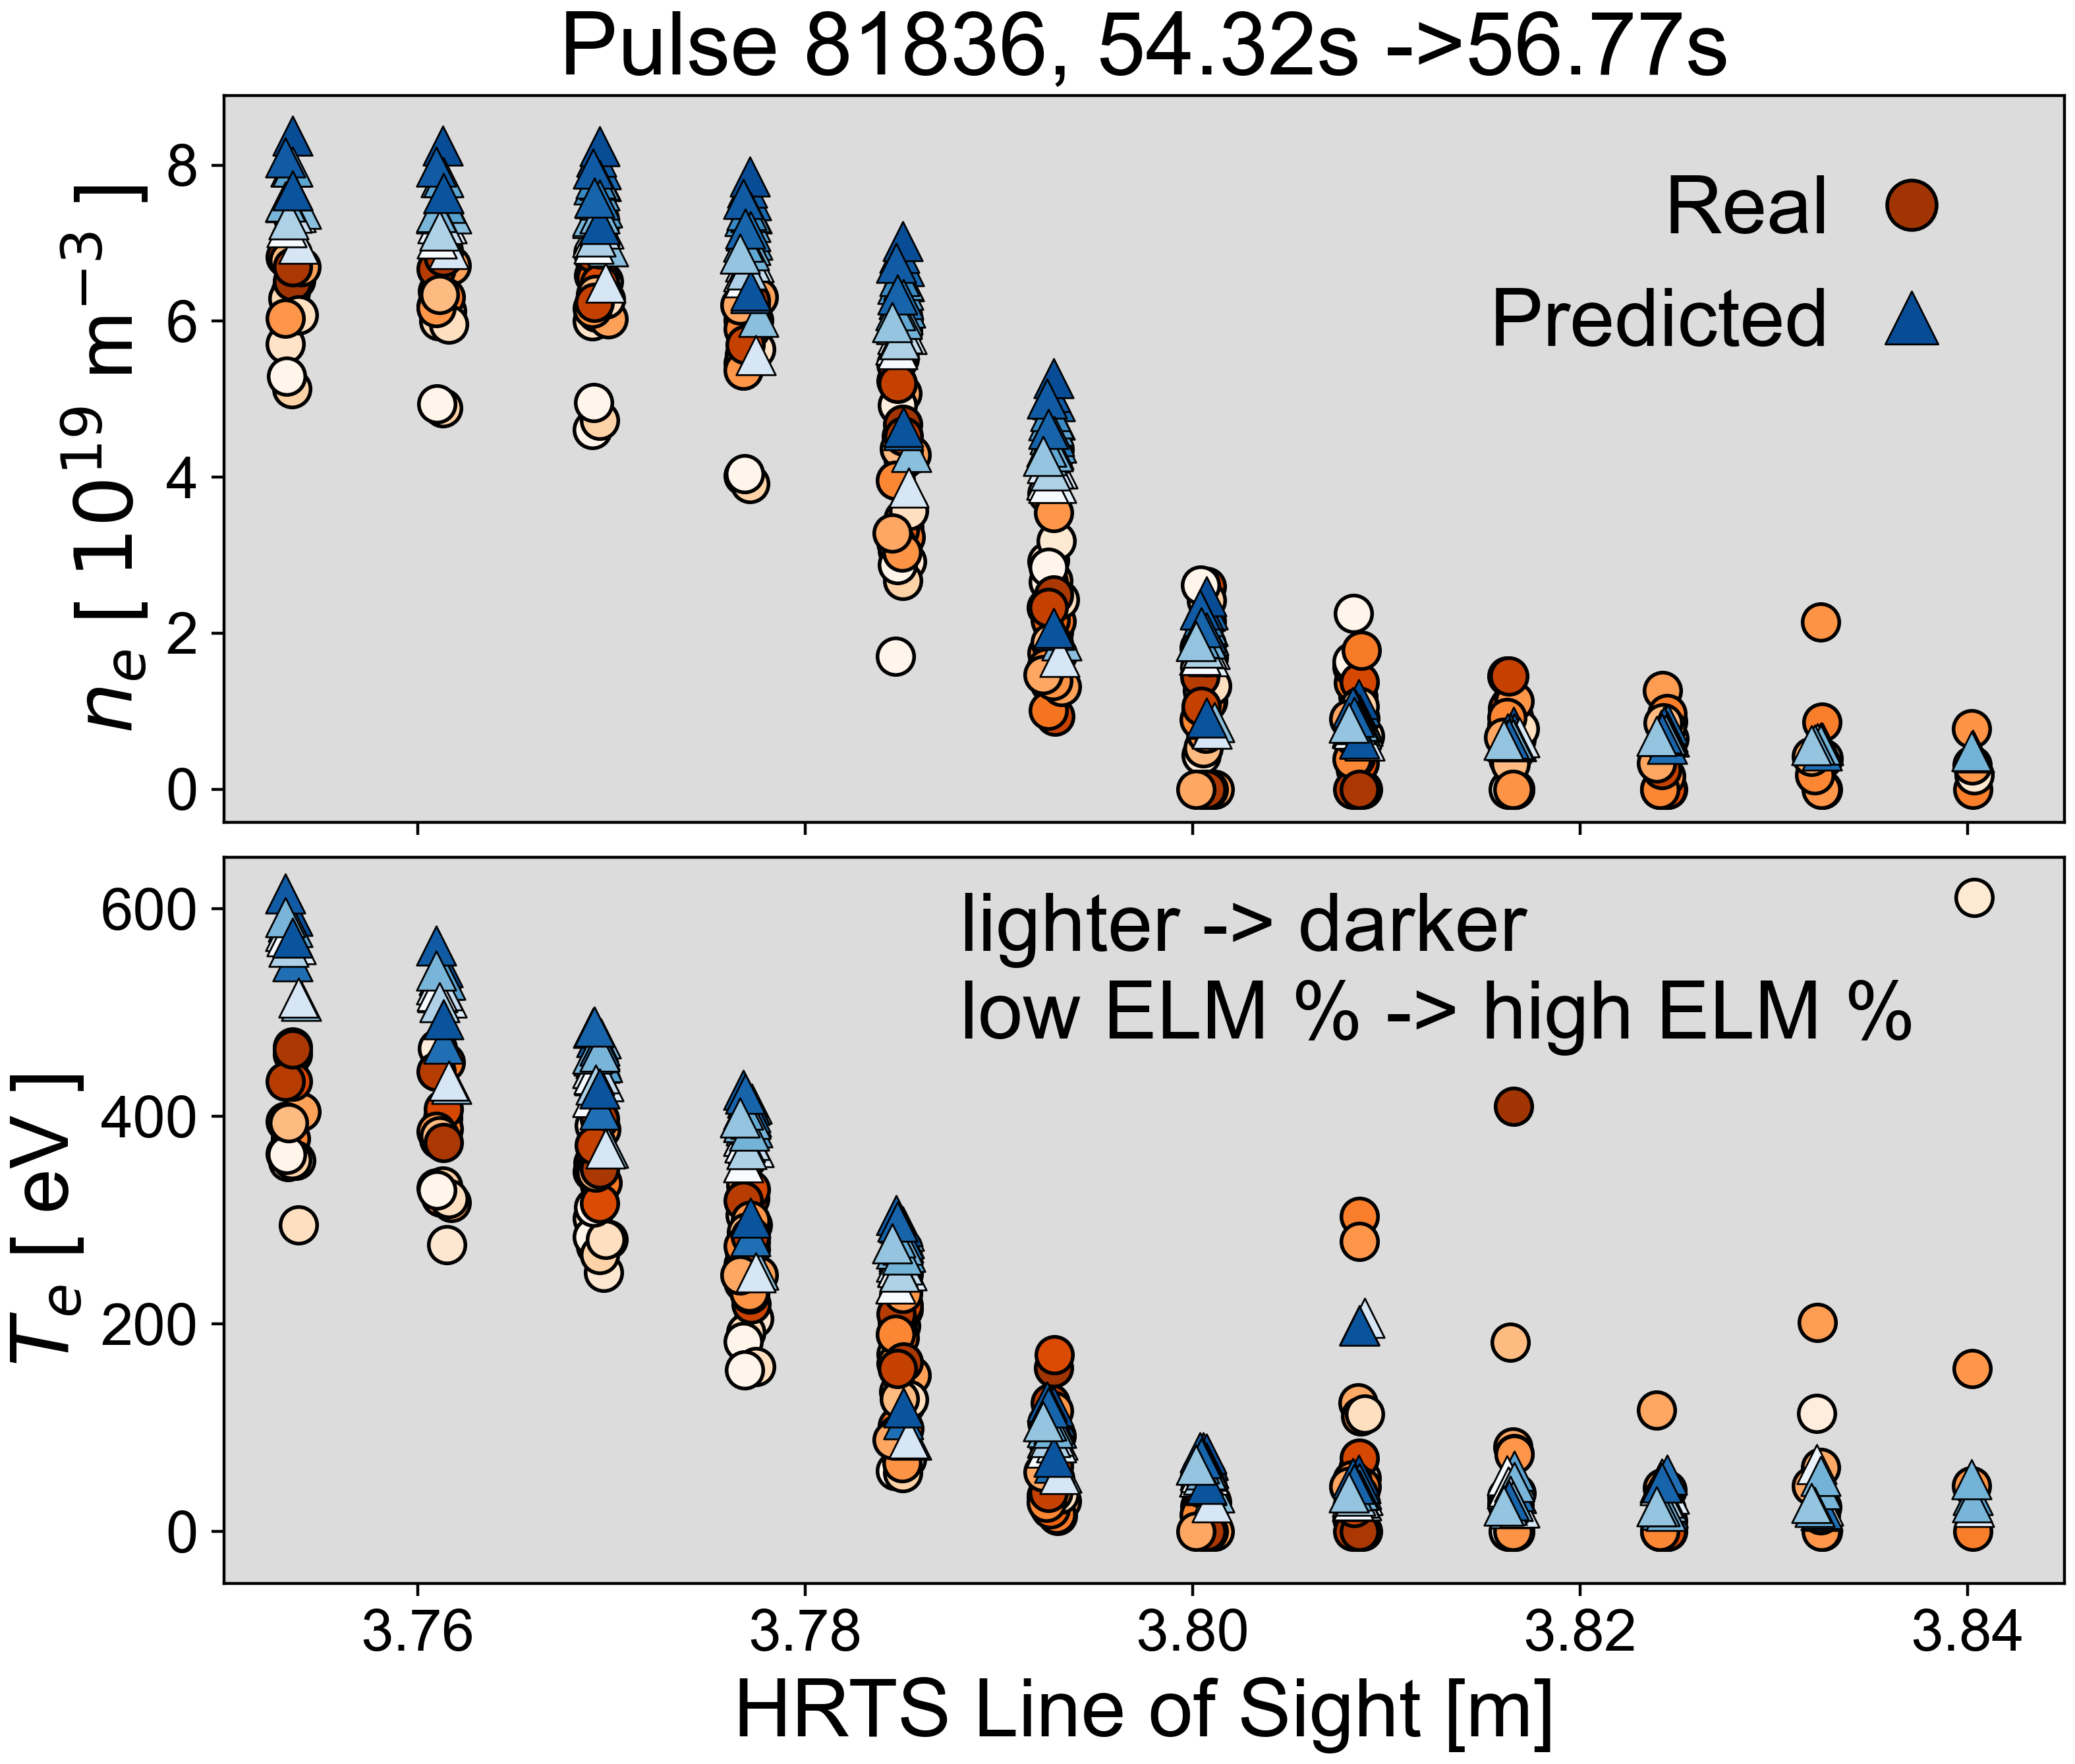

In [340]:
# ml_dict['test'].keys()
# test_profs, test_neseps, test_ids, test_mps, test_elm_perc, _, test_rmids, test_masks, test_rseps = ml_dict['test'].values()
# 2, 7
start, end = 63, 98

# print(test_ids[start: end], test_neseps[start: end], test_elm_perc[start:end])
 
pre_elm_idx, post_elm_idx = 76, 68
# Get relevant pulses 
test_profs, test_neseps, test_ids, test_mps, test_elm_perc, _, test_rmids, test_masks, test_rseps = ml_dict['test'].values()

relevant_pulse = torch.from_numpy(test_profs[start:end]), test_rmids[start:end], torch.from_numpy(test_elm_perc[start:end]), torch.from_numpy(test_mps[start:end]), test_rseps[start:end], test_neseps[start:end], torch.from_numpy(test_masks[start:end]) > 0
# profs, rmids, elm_perc, mps, rsep, nesep, masks

# normalize profiles and mps 
profs_norm, mps_norm = torch.clone(relevant_pulse[0]), torch.clone(relevant_pulse[3])
profs_norm = normalize_profiles(profs_norm, T_mu, T_var, D_mu, D_var)
mps_norm = standardize(mps_norm, MP_mu, MP_var)

# add elm perc to profiles and mps 

MPS = torch.column_stack((mps_norm, relevant_pulse[2])).float()
elm_prof = torch.repeat_interleave(relevant_pulse[2].unsqueeze(1), 19, 1).unsqueeze(1)
X_norm = torch.concat((profs_norm, elm_prof), 1).float()

with torch.no_grad(): 
    cond_mu, cond_var =  model.p_zmachx(MPS)
    z_mach = model.reparameterize(cond_mu, cond_var)
    mu_stoch, log_var_stoch, mu_mach, log_var_mach = model.q_zy(X_norm)
    z_stoch = mu_stoch
    z_mach = cond_mu
    z_conditional = torch.cat((z_stoch, z_mach), 1)
    out_profs_cond = model.p_yhatz(z_conditional)
    
out_profs_cond[:, 0] = de_standardize(out_profs_cond[:, 0], D_mu, D_var)
out_profs_cond[:, 1] = de_standardize(out_profs_cond[:, 1], T_mu, T_var)

plt.close('all')
Blues = plt.get_cmap('Blues')
Oranges = plt.get_cmap('Oranges')
fig, (n_ax, t_ax) = plt.subplots(2, 1, figsize=(20*cm, 17*cm), constrained_layout=True, sharex=True, dpi=400)
# print(relevant_pulse[2])
for n, (prof, rmid, elm, mask, neseps, rseps) in enumerate(zip(relevant_pulse[0], relevant_pulse[1], relevant_pulse[2], relevant_pulse[-1], relevant_pulse[-2], relevant_pulse[-3])):
    if n == 30: 
        continue
    if elm.numpy().item() > 0.88: 
        label_pred = 'Predicted'
        label_real = 'Real'
    else: 
        label_pred = None
        label_real = None
    n_ax.scatter(rmid[mask], prof[0][mask]*1e-19, color=Oranges(elm.numpy()), edgecolor=(0, 0, 0), s=100, label=label_real)
    t_ax.scatter(rmid[mask], prof[1][mask], color=Oranges(elm.numpy()), edgecolor=(0, 0, 0), s=100)
for n, (prof, rmid, elm, mask) in enumerate(zip(out_profs_cond, relevant_pulse[1], relevant_pulse[2], relevant_pulse[-1])):
    if n == 30: 
        continue
    if elm.numpy().item() > 0.88: 
        label_pred = 'Predicted'
        label_real = 'Real'
    else: 
        label_pred = None
        label_real = None
        
    to_plot_r, to_plot_n, to_plot_t = rmid[mask], prof[0][mask]*1e-19, prof[1][mask]
    SOL = to_plot_r > 3.81
    to_plot_t[SOL] = abs(torch.normal(0, 20, size=(1, SOL.sum()))) + 20
    n_ax.scatter(to_plot_r, to_plot_n, color=Blues(elm.numpy()),  edgecolor=(0, 0, 0), lw=0.5, marker='^', s=115, label=label_pred)
    t_ax.scatter(to_plot_r, to_plot_t, color=Blues(elm.numpy()), marker='^', s=115, edgecolor=(0, 0, 0), lw=0.5,)
    
# n_ax.scatter(relevant_pulse[1][relevant_pulse[-1]], relevant_pulse[0][:, 0][relevant_pulse[-1]])
# t_ax.scatter(relevant_pulse[1][relevant_pulse[-1]], relevant_pulse[0][:, 1][relevant_pulse[-1]])
n_ax.legend(loc='upper right', frameon=False, fontsize=MEDIUM_SIZE, handletextpad=0.01, markerscale=1.35, markerfirst=False, labelspacing=0.4, handleheight=1.05)
t_ax.set_ylim(-50, 650)
t_ax.set_xlim(3.75, 3.845)
n_ax.set_facecolor('gainsboro')
t_ax.set_facecolor('gainsboro')
t_ax.set_ylabel('$T_e$ [ eV ]')
n_ax.set_ylabel('$n_e$ [ $10^{19}$ m$^{-3}$ ]')
t_ax.set_xlabel('HRTS Line of Sight [m]')
t_ax.annotate('lighter -> darker\nlow ELM % -> high ELM %', xy=(0.4, 0.75), xycoords='axes fraction', fontsize=MEDIUM_SIZE)
n_ax.set_title('Pulse 81836, 54.32s ->56.77s')
plt.savefig('/home/kitadam/ENR_Sven/moxie/docs/source/poster/pred_vs_real_pulse_81836.svg')
# plt.savefig('/home/kitadam/ENR_Sven/moxie/docs/source/poster/pred_vs_real_pulse_81836.png')
# plt.show()

# Figure 3: Results Figure

3 Fotos, vertically stacked
- XGBoost: pred nesep vs Lorenzo Dataset
- XGBoost pred nesep vs our nesep 
- VAE: pred nesep vs our nesep

In [216]:
# boilerplate stuff
import math
from collections.abc import Iterable

class RunningStats:
    def __init__(self):
        self.n = 0
        self.old_m = 0
        self.new_m = 0
        self.old_s = 0
        self.new_s = 0

    def clear(self):
        self.n = 0

    def push(self, x):
        if isinstance(x, Iterable):
            for v in x:
                self.push(v)
            return

        self.n += 1

        if self.n == 1:
            self.old_m = self.new_m = x
            self.old_s = 0
        else:
            self.new_m = self.old_m + (x - self.old_m) / self.n
            self.new_s = self.old_s + (x - self.old_m) * (x - self.new_m)

            self.old_m = self.new_m
            self.old_s = self.new_s

    def mean(self):
        return self.new_m if self.n else 0.0

    def variance(self):
        return self.new_s / (self.n - 1) if self.n > 1 else 0.0

    def standard_deviation(self):
        return math.sqrt(self.variance())

    def __repr__(self):
        return f'n: {self.n}, mean: {self.mean()}, var: {self.variance()}, sd: {self.standard_deviation()}'
    
def standardize_signal(x, trim_zeros=True):
    if trim_zeros:
        x_in = np.trim_zeros(x)
    else:
        x_in = x
    rs = RunningStats() # numpy.std goes to inf so do it by hand
    rs.push(x_in)
    return (x - rs.mean()) / rs.standard_deviation()

def find_nearest(query, data, idx_must_be='any'):
    if idx_must_be not in ['any', 'smaller', 'greater']:
        raise ValueError('"idx_must_be" must be in [any, smaller, greater]')
    # ASSUMED A SORTED ARRAY [INCREASING] #
    # optionally, if query is inbetween elements, can pick which direction op
    if query < data[0]:
        if idx_must_be == 'smaller':
            raise ValueError('Cannot return smaller value as "query" is smaller than any datapoint')
        return 0
    elif query > data[-1]:
        if idx_must_be == 'greater':
            raise ValueError('Cannot return greater value as "query" is greater than any datapoint')
        return len(data)-1
    else:
        idx = np.searchsorted(data, query, side='left')
        if data[idx] == query:
            return idx
        elif idx_must_be == 'any':
            if abs(query - data[idx-1]) < abs(query - data[idx]):
                return idx-1
            else:
                return idx
        elif idx_must_be == 'greater':
            return idx
        elif idx_must_be == 'smaller':
            return idx - 1
        else:
            raise ValueError('invalid argument for "idx_must_be"')
            
def get_nearest_weighted_idx(query, data, sort=True):
    if sort:
        unsorted = np.array(data)
        sortidx = np.argsort(data)
        sort_reverse = {i: sortidx[i] for i in range(len(data))}

        data = np.array(data)[sortidx]
    data = list(data)
    if query in data: # exact match
        idx = [(1, data.index(query))] # weight, index
    elif query < data[0]: # before first
        idx = [(1, 0)] 
    elif query > data[-1]: # after last
        idx = [(1, len(data)-1)]
    else:
        # get nearest two elements
        i_r = np.searchsorted(data, query)
        i_l = i_r - 1
        dist = data[i_r] - query + query - data[i_l]
        idx = [(1-(data[i_r] - query)/dist, i_r), (1-(query - data[i_l])/dist, i_l)]

    # convert back to unsorted idx
    if sort:
        idx = [(w, sort_reverse[i]) for (w, i) in idx]
    return idx
def pedestal_top(p, x, plot_result=False):
    # standardize signal
    p = standardize_signal(p, trim_zeros=True)

    # interp signal to Nx=50
    f_interp = interpolate.interp1d(x, p)
    x_h = np.linspace(x[0], x[-1], 50)  # interpolate to 50 (evenly spaced) points
    p_h = f_interp(x_h)

    # smooth with savgol filter
    p_s = savgol_filter(p_h, window_length=11, polyorder=3)

    # get max gradient so we're in the pedestal
    p_s_grad = np.gradient(p_s)
    min_i = np.argmin(p_s_grad)


    # search from pedestal region outward in 2nd derivatives
    p_s_grad2 = np.gradient(p_s_grad)
    p_s_grad2 = savgol_filter(p_s_grad2, window_length=11, polyorder=3)  # aggressively smooth as well
    p_s_grad2 = standardize_signal(p_s_grad2, trim_zeros=True)
    # standardize s.t. if we go >1 sd up/down, we stop searching

    # go to the left from middle point
    sd_cutoff = -.5
    start_cut_early = False  # if we go < -1 for x'', mark as such, such that if we go > -1 again we stop looking
    min_val = p_s_grad2[min_i]
    top_i = min_i
    for i in reversed(range(0, min_i)):
        if p_s_grad2[i] < min_val:
            min_val = p_s_grad2[i]
            top_i = i
            if min_val < sd_cutoff:
                start_cut_early = True
        elif start_cut_early and p_s_grad2[i] > sd_cutoff:
            break

    # found our x for top
    # same procedure for bottom
    sd_cutoff = .5
    start_cut_early = False  # if we go > 1 for x'', etc.
    max_val = p_s_grad2[min_i]
    bottom_i = min_i

    for i in range(min_i+1, x_h.shape[0]):
        if p_s_grad2[i] > max_val:
            max_val = p_s_grad2[i]
            bottom_i = i
            if max_val > sd_cutoff:
                start_cut_early = True
        elif start_cut_early and p_s_grad2[i] < sd_cutoff:
            break

    top, bottom = x_h[top_i], x_h[bottom_i]

    if plot_result:
        plt.plot(x_h, p_s)
        plt.axvline(top, color='red', label='estimated top')
        plt.axvline(bottom, color='blue', label='estimated bottom')
        plt.legend()
        plt.show()
    return top, bottom

def find_separatrix(ne, te, x, plot_result=False):
    top_x, bottom_x = pedestal_top(ne, x, plot_result=False)
    
    # initial estimate
    x_sep = (1/4) * top_x + (3/4) * bottom_x
    x_initial = x_sep
    # scan area around x_sep
    # first, interp to higher space
    x_h = np.linspace(x[0], x[-1], 200)  # interpolate to 50 (evenly spaced) points
    
    f_ne_interp = interpolate.interp1d(x, ne)
    ne_h = f_ne_interp(x_h)
    ne_s = savgol_filter(ne_h, window_length=11, polyorder=3)
    f_te_interp = interpolate.interp1d(x, te)
    te_h = f_te_interp(x_h)
    te_s = savgol_filter(te_h, window_length=11, polyorder=3)
    
    # closest x
    s_i = find_nearest(x_sep, x_h)
    # scan inwards/outwards
    n_step = 10
    te_target = 100 # 100 eV
    te_distr = norm(te_target, 10)  # distribution to weigh new points against
    weight_func = lambda x: x ** 0.05
    
    def te_sep():
        idx = get_nearest_weighted_idx(x_sep, x_h, sort=False)
        val_out = 0
        for w, w_i in idx:
            val_out += w * te_s[w_i]
        return val_out
    
    for i in range(1, n_step+1):
        i_left = s_i - i
        i_right = s_i + i
        if i_left < 0 or i_right > x_h.shape[0] - 1:
            break  # reached outside the grid on 1 side
        weight_pos = i / n_step  # [1/n, 1] adjustment based on how far the value is 'good'
        pdf_l = te_distr.pdf(te_s[i_left])
        adjust_l = weight_pos * pdf_l
        adjust_l = weight_func(adjust_l)
        if te_s[i_left] > te_target and te_sep() < te_target:  # on the left is above 100 --> we need to move left
            x_sep = (x_sep + x_h[i_left] * adjust_l) / (1 + adjust_l)

        pdf_r = te_distr.pdf(te_s[i_right])
        adjust_r = weight_pos * pdf_r
        adjust_r = weight_func(adjust_r)
        if te_s[i_right] < te_target and te_sep() > te_target:  # on the right is below 100 --> we need to move right
            x_sep = (x_sep + x_h[i_right] * adjust_r) / (1 + adjust_r)
    
    # closest_x_index = np.argmin(abs(x_h - x_sep))
    # from_fit = x_h[closest_x_index], te_h[closest_x_index], ne_h[closest_x_index]
    interp_idx_l, interp_idx_r = get_idx_for_linear_interp(x_sep, x, te)
    weights_r, weights_l = get_weights(te, interp_idx_l, interp_idx_r)
    tesep_estimation = weights_l*te[interp_idx_l] + weights_r*te[interp_idx_r]
    nesep_estimation = weights_l*ne[interp_idx_l] + weights_r*ne[interp_idx_r]
    rsep_estimation = weights_l*x[interp_idx_l] + weights_r*x[interp_idx_r]
    if nesep_estimation < 0: 
        plot_result = True
    if plot_result:
        fig, axs=plt.subplots(1, 2, figsize=(6,3))
        axs[0].plot(x_h, te_s)
        axs[0].scatter(x, te)
        axs[0].scatter(x[interp_idx_l], te[interp_idx_l], color='orange')
        axs[0].scatter(x[interp_idx_r], te[interp_idx_r], color='orange')
        
        axs[0].axvline(x_initial, color='red', label='initial estimate')
        axs[0].axvline(x_sep, color='green', label='final estimate')
        axs[0].axhline(100, color='black', label='100eV')
        axs[0].scatter(rsep_estimation, tesep_estimation, color='black',marker='*', s=250)

        axs[1].plot(x_h, ne_s)
        axs[1].scatter(x, ne)
        axs[1].scatter(rsep_estimation, nesep_estimation, color='black',marker='*', s=250)
        axs[1].axvline(x_initial, color='red', label='initial prior')
        axs[1].axvline(x_sep, color='green', label='final prior')
        axs[1].axvline(rsep_estimation, color='black', ls='--', label='final est')
        axs[1].scatter(x[interp_idx_l], ne[interp_idx_l], color='orange')
        axs[1].scatter(x[interp_idx_r], ne[interp_idx_r], color='orange')
        axs[1].legend()
        
        plt.show()
    
    return tesep_estimation, nesep_estimation, rsep_estimation

def get_idx_for_linear_interp(x_sep, x, te): 
    closest_point = np.argmin(abs(x - x_sep))
    if (te < 100).sum() == 0: 
        closest_point = np.argmin(abs(te - 100))
        idx_r = closest_point
        idx_l = idx_r - 1
   
    elif te[closest_point] < 100: 
        idx_r = closest_point
        idx_l = closest_point - 1
        while te[idx_l] < 100: 
            idx_r = idx_l
            idx_l = idx_l - 1
    else: 
        idx_r = closest_point + 1
        idx_l = closest_point
        while te[idx_r] > 100:
            idx_l = idx_r
            idx_r = idx_l + 1
            
    return idx_l, idx_r 
def get_weights(te, idx_l, idx_r, query=100): 
    dist = te[idx_r] - query + query - te[idx_l]
    weights = (1-(te[idx_r] - query)/dist, 1-(query - te[idx_l])/dist) 
    return weights

In [227]:
# VAE PREDS 

# Gather train-val-test
train_profs, train_neseps, train_ids, train_mps, train_elm_perc, _, train_rmids, train_masks, train_rseps = ml_dict['train'].values()
val_profs, val_neseps, val_ids, val_mps, val_elm_perc, _, val_rmids, val_masks, val_rseps = ml_dict['val'].values()
test_profs, test_neseps, test_ids, test_mps, test_elm_perc, _, test_rmids, test_masks, test_rseps = ml_dict['test'].values()

# Configure the inputs 

"""
Training
"""
# normalize profiles and mps 
profs_norm, mps_norm = torch.clone(torch.from_numpy(train_profs)), torch.clone(torch.from_numpy(train_mps))
profs_norm = normalize_profiles(profs_norm, T_mu, T_var, D_mu, D_var)
mps_norm = standardize(mps_norm, MP_mu, MP_var)

# add elm perc to profiles and mps 

MPS = torch.column_stack((mps_norm, torch.from_numpy(train_elm_perc))).float()
elm_prof = torch.repeat_interleave(torch.from_numpy(train_elm_perc).unsqueeze(1), 19, 1).unsqueeze(1)
X_norm = torch.concat((profs_norm, elm_prof), 1).float()

# Propogate through model
with torch.no_grad(): 
    cond_mu, cond_var =  model.p_zmachx(MPS)
    z_mach = model.reparameterize(cond_mu, cond_var)
    mu_stoch, log_var_stoch, mu_mach, log_var_mach = model.q_zy(X_norm)
    z_stoch = mu_stoch
    z_mach = cond_mu
    z_conditional = torch.cat((z_stoch, z_mach), 1)
    out_profs_cond = model.p_yhatz(z_conditional)

out_profs_cond[:, 0] = de_standardize(out_profs_cond[:, 0], D_mu, D_var)
out_profs_cond[:, 1] = de_standardize(out_profs_cond[:, 1], T_mu, T_var)

# Get nesep from profiles
plt.close('all')
train_neseps_pred = np.zeros(len(train_neseps))
for n, (profs, rmids, mask) in enumerate(zip(out_profs_cond, train_rmids, train_masks > 0)): 
    ne, te, x = profs[0][mask].numpy(), profs[1][mask].numpy(), rmids[mask]
    
    new_ne, new_te =  np.minimum.accumulate(ne), np.minimum.accumulate(te)
    keep_idx = np.where(new_te == te)

    ne, te, x = new_ne[keep_idx], new_te[keep_idx], x[keep_idx]
    if (te < 100).sum() == 0 or len(te) < 2: 
        continue
    try: 
        estimations = find_separatrix(ne, te, x, plot_result=False)
    except IndexError as e:
        continue
    else: 
        train_neseps_pred[n] = (estimations[1])
        

"""
Validation
"""
print('val')
# normalize profiles and mps 
profs_norm, mps_norm = torch.clone(torch.from_numpy(val_profs)), torch.clone(torch.from_numpy(val_mps))
profs_norm = normalize_profiles(profs_norm, T_mu, T_var, D_mu, D_var)
mps_norm = standardize(mps_norm, MP_mu, MP_var)

# add elm perc to profiles and mps 

MPS = torch.column_stack((mps_norm, torch.from_numpy(val_elm_perc))).float()
elm_prof = torch.repeat_interleave(torch.from_numpy(val_elm_perc).unsqueeze(1), 19, 1).unsqueeze(1)
X_norm = torch.concat((profs_norm, elm_prof), 1).float()

# Propogate through model
with torch.no_grad(): 
    cond_mu, cond_var =  model.p_zmachx(MPS)
    z_mach = model.reparameterize(cond_mu, cond_var)
    mu_stoch, log_var_stoch, mu_mach, log_var_mach = model.q_zy(X_norm)
    z_stoch = mu_stoch
    z_mach = cond_mu
    z_conditional = torch.cat((z_stoch, z_mach), 1)
    out_profs_cond = model.p_yhatz(z_conditional)

out_profs_cond[:, 0] = de_standardize(out_profs_cond[:, 0], D_mu, D_var)
out_profs_cond[:, 1] = de_standardize(out_profs_cond[:, 1], T_mu, T_var)

# Get nesep from profiles
plt.close('all')
val_neseps_pred = np.zeros(len(val_neseps))
for n, (profs, rmids, mask) in enumerate(zip(out_profs_cond, val_rmids, val_masks > 0)): 
    ne, te, x = profs[0][mask].numpy(), profs[1][mask].numpy(), rmids[mask]
    
    new_ne, new_te =  np.minimum.accumulate(ne), np.minimum.accumulate(te)
    keep_idx = np.where(new_te == te)

    ne, te, x = new_ne[keep_idx], new_te[keep_idx], x[keep_idx]
    if (te < 100).sum() == 0 or len(te) < 2: 
        continue
    try: 
        estimations = find_separatrix(ne, te, x, plot_result=False)
    except IndexError as e:
        continue
    else: 
        val_neseps_pred[n] = (estimations[1])
        
"""
Validation
"""
print('test')
# normalize profiles and mps 
profs_norm, mps_norm = torch.clone(torch.from_numpy(test_profs)), torch.clone(torch.from_numpy(test_mps))
profs_norm = normalize_profiles(profs_norm, T_mu, T_var, D_mu, D_var)
mps_norm = standardize(mps_norm, MP_mu, MP_var)

# add elm perc to profiles and mps 

MPS = torch.column_stack((mps_norm, torch.from_numpy(test_elm_perc))).float()
elm_prof = torch.repeat_interleave(torch.from_numpy(test_elm_perc).unsqueeze(1), 19, 1).unsqueeze(1)
X_norm = torch.concat((profs_norm, elm_prof), 1).float()

# Propogate through model
with torch.no_grad(): 
    cond_mu, cond_var =  model.p_zmachx(MPS)
    z_mach = model.reparameterize(cond_mu, cond_var)
    mu_stoch, log_var_stoch, mu_mach, log_var_mach = model.q_zy(X_norm)
    z_stoch = mu_stoch
    z_mach = cond_mu
    z_conditional = torch.cat((z_stoch, z_mach), 1)
    out_profs_cond = model.p_yhatz(z_conditional)

out_profs_cond[:, 0] = de_standardize(out_profs_cond[:, 0], D_mu, D_var)
out_profs_cond[:, 1] = de_standardize(out_profs_cond[:, 1], T_mu, T_var)

# Get nesep from profiles
plt.close('all')
test_neseps_pred = np.zeros(len(test_neseps))
for n, (profs, rmids, mask) in enumerate(zip(out_profs_cond, test_rmids, test_masks > 0)): 
    ne, te, x = profs[0][mask].numpy(), profs[1][mask].numpy(), rmids[mask]
    
    new_ne, new_te =  np.minimum.accumulate(ne), np.minimum.accumulate(te)
    keep_idx = np.where(new_te == te)

    ne, te, x = new_ne[keep_idx], new_te[keep_idx], x[keep_idx]
    if (te < 100).sum() == 0 or len(te) < 2: 
        continue
    try: 
        estimations = find_separatrix(ne, te, x, plot_result=False)
    except IndexError as e:
        continue
    else: 
        test_neseps_pred[n] = (estimations[1])

/tmp/ipykernel_68093/1157624469.py:53: RuntimeWarning: invalid value encountered in true_divide
  return (x - rs.mean()) / rs.standard_deviation()


val
test


In [224]:
# Get xgboost results

with open('/home/kitadam/ENR_Sven/moxie/experiments/PSI_22/model_results/xgboost_vs_uns.pickle', 'rb') as file: 
    xgboost_vs_uns = pickle.load(file)
with open('/home/kitadam/ENR_Sven/moxie/experiments/PSI_22/model_results/xgboost_vs_lor.pickle', 'rb') as file: 
    xgboost_vs_lor = pickle.load(file)


5.856669220732287e+19


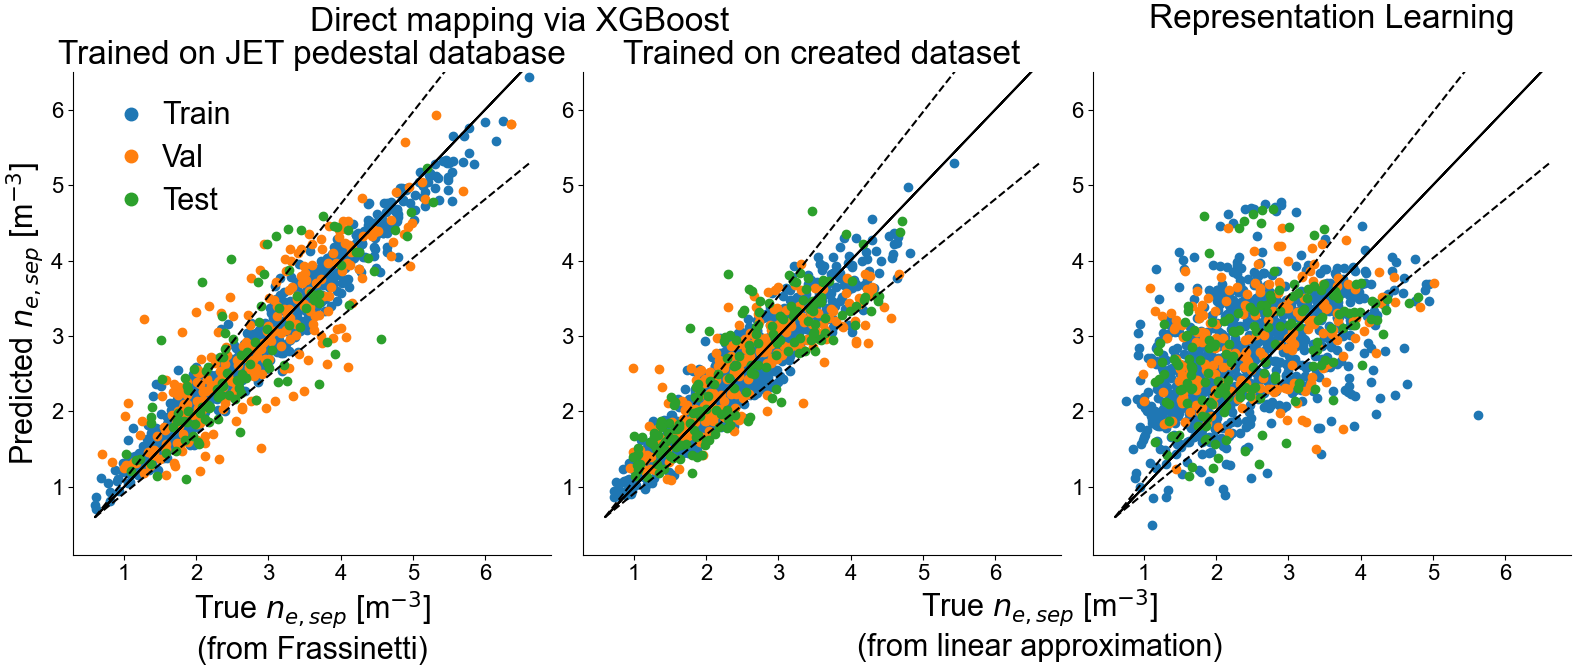

In [339]:
plt.close('all')
from sklearn.model_selection import train_test_split 
min_val = np.amin(xgboost_vs_lor['train'][1]) + 1e18
max_val = np.amax(xgboost_vs_lor['train'][1])

bins     = np.linspace(start=min_val, stop=max_val, num=50)
y_binned = np.digitize(train_neseps, bins, right=True)
_, X_train, _, y_train = train_test_split(train_neseps_pred, train_neseps, stratify=y_binned, test_size=0.08)

y_binned = np.digitize(val_neseps, bins, right=True)
_, X_val, _, y_val = train_test_split(val_neseps_pred, val_neseps, stratify=y_binned, test_size=0.08)

y_binned = np.digitize(test_neseps, bins, right=True)
_, X_test, _, y_test = train_test_split(test_neseps_pred, test_neseps, stratify=y_binned, test_size=0.08)


fig, (ax_lor, ax_uns, vae) = plt.subplots(1, 3, figsize=(40*cm, 17*cm), constrained_layout=True, sharex=True, sharey=True)# , dpi=400)

vae.scatter(y_train*1e-19, X_train*1e-19,)
vae.scatter(y_val*1e-19, X_val*1e-19,)
vae.scatter(y_test*1e-19, X_test*1e-19,)
vae.set_title('Representation Learning\n')

ax_lor.scatter(xgboost_vs_lor['train'][1], xgboost_vs_lor['train'][0], label='Train')
ax_lor.scatter(xgboost_vs_lor['val'][1], xgboost_vs_lor['val'][0], label='Val')
ax_lor.scatter(xgboost_vs_lor['test'][1], xgboost_vs_lor['test'][0], label='Test')

ax_lor.set_title('Trained on JET pedestal database')

bins     = np.linspace(start=min_val, stop=max_val, num=50)
y_binned = np.digitize(xgboost_vs_uns['train'][1], bins, right=True)
_, X_train, _, y_train = train_test_split(xgboost_vs_uns['train'][0], xgboost_vs_uns['train'][1], stratify=y_binned, test_size=0.08)

y_binned = np.digitize(xgboost_vs_uns['val'][1], bins, right=True)
_, X_val, _, y_val = train_test_split(xgboost_vs_uns['val'][0], xgboost_vs_uns['val'][1], stratify=y_binned, test_size=0.08)

y_binned = np.digitize(xgboost_vs_uns['test'][1], bins, right=True)
_, X_test, _, y_test = train_test_split(xgboost_vs_uns['test'][0], xgboost_vs_uns['test'][1], stratify=y_binned, test_size=0.08)

ax_uns.scatter(y_train*1e-19, X_train*1e-19,)
ax_uns.scatter(y_val*1e-19, X_val*1e-19,)
ax_uns.scatter(y_test*1e-19, X_test*1e-19,)

print(max(xgboost_vs_uns['train'][1]))
ax_uns.set_title('Trained on created dataset')
ax_lor.set_ylabel('Predicted $n_{e, sep}$ [m$^{-3}$]')
vae.set_ylim(0.1, 6.5)

ax_lor.legend(loc='upper left', frameon=False, fontsize=MEDIUM_SIZE, handletextpad=0.01, markerscale=1.5, labelspacing=0.4, handleheight=1.05)

ax_lor.set_xlabel('True $n_{e, sep}$ [m$^{-3}$]\n(from Frassinetti)')
fig.suptitle('Direct mapping via XGBoost', x=0.33, y=0.99)
fig.supxlabel('True $n_{e, sep}$ [m$^{-3}$]\n(from linear approximation)', x=0.66, y=0.01, fontsize=MEDIUM_SIZE)

for ax in [ax_lor, ax_uns, vae]:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.plot(xgboost_vs_lor['train'][1], xgboost_vs_lor['train'][1], color='black', label='Unity')
    ax.plot([min(xgboost_vs_lor['train'][1]), max(xgboost_vs_lor['train'][1])], [min(xgboost_vs_lor['train'][1]), 0.8*max(xgboost_vs_lor['train'][1])], color='black', ls='--')
    ax.plot([min(xgboost_vs_lor['train'][1]), max(xgboost_vs_lor['train'][1])], [min(xgboost_vs_lor['train'][1]), 1.2*max(xgboost_vs_lor['train'][1])], color='black', ls='--')

plt.savefig('/home/kitadam/ENR_Sven/moxie/docs/source/poster/all_comparison_fig.png')
plt.show()

# Figure 3: Latent representation to profile representation 



In [221]:
def reduced_find_separatrix(ne, te, x, plot_result=False):
    idx_r, idx_l = -1, -2
    weights_r, weights_l = get_weights(te, idx_l, idx_r)
    tesep_estimation = weights_l*te[idx_l] + weights_r*te[idx_r]
    nesep_estimation = weights_l*ne[idx_l] + weights_r*ne[idx_r]
    rsep_estimation = weights_l*x[idx_l] + weights_r*x[idx_r]
    return tesep_estimation, nesep_estimation, rsep_estimation

In [341]:
sample_size = 1000

ld_1, ld_2 = 4, -1

# print(torch.mean(z_mach, 0))
z_mach_sample = torch.tile(torch.mean(z_mach, 0), (sample_size, 1))
z_stoch_sample = torch.tile(torch.mean(z_stoch, 0), (sample_size, 1))

#z_mach_sample = torch.zeros((sample_size, 9))
# z_stoch_sample = torch.zeros((sample_size, 3))
# z_mach_sample[:, 2] = z_mach_sample[:, 2] -5
# z_mach_sample[:, 3] = z_mach_sample[:, 3] + 5
# z_mach_sample[:, 5] = z_mach_sample[:, 5] - 7
# z_mach_sample[:, 6] = z_mach_sample[:, 6] + 2
# z_mach_sample[:, 7] = z_mach_sample[:, 7] - 2

z_mach_sample[:, ld_1] = torch.linspace(-10, max(z_mach[:, ld_1])/2.0, sample_size) + torch.normal(0, 0.5, size=(1, sample_size))
z_mach_sample[:, ld_2] = torch.linspace(min(z_mach[:, ld_2])/3.0,max(z_mach[:, ld_2])/5.0, sample_size) + torch.normal(0, 0.5, size=(1, sample_size))
with torch.no_grad(): 
    z_conditional_sample = torch.cat((z_stoch_sample, z_mach_sample), 1)
    out_profs_cond_sample = model.p_yhatz(z_conditional_sample)
    out_profs_cond_sample[:, 0] = de_standardize(out_profs_cond_sample[:, 0], D_mu, D_var)
    out_profs_cond_sample[:, 1] = de_standardize(out_profs_cond_sample[:, 1], T_mu, T_var)
    
sample_rmids = np.tile(np.linspace(3.75, 3.95, 19), (sample_size, 1))
sample_neseps_pred = np.zeros(len(sample_rmids))

for n, (profs, rmids) in enumerate(zip(out_profs_cond_sample, sample_rmids)): 
    ne, te, x = profs[0].numpy(), profs[1].numpy(), rmids
    new_ne, new_te =  np.minimum.accumulate(ne), np.minimum.accumulate(te)
    keep_idx = np.where(new_te == te)

    ne, te, x = new_ne[keep_idx], new_te[keep_idx], x[keep_idx]
    
    logical_mask = te > 0
    
    ne, te, x = ne[logical_mask], te[logical_mask], x[logical_mask]
    
    if (te < 100).sum() == 0 or len(te) < 2: 
        # print(ne, te)
        continue
    try: 
        estimations = reduced_find_separatrix(ne, te, x)
    except IndexError as e:
        print(ne, te, x)   
        continue
    except AttributeError as e: 
        print(ne, te, x)   
        continue
    else: 
        sample_neseps_pred[n] = (estimations[1])


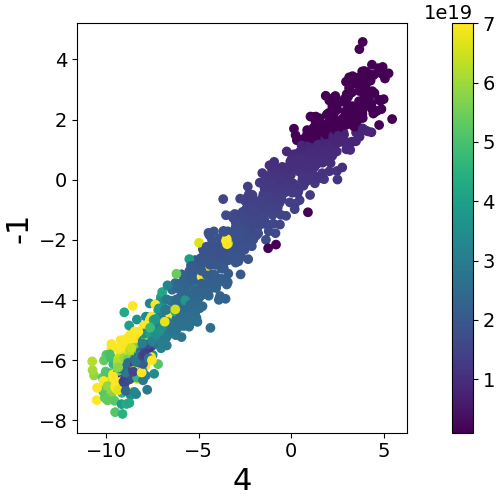

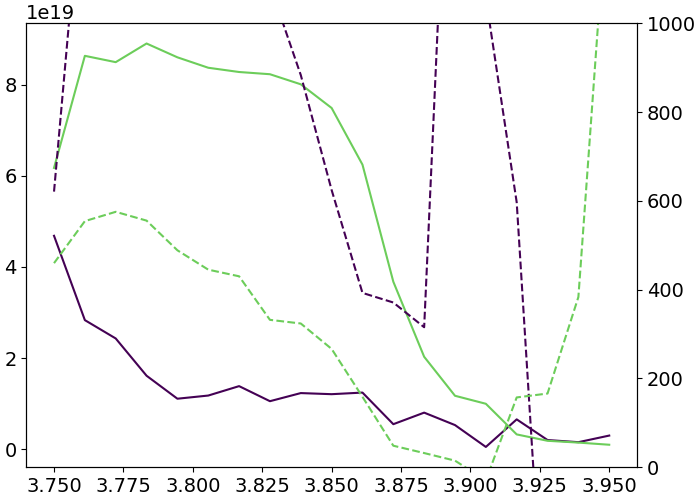

In [342]:
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=1e18, vmax=7e19)
sample_1, sample_2 = -1, 0
plt.close('all')
plot_idx_1, plot_idx_2 = ld_1, ld_2
fig = plt.figure(figsize=(5, 5), constrained_layout=True)
cax = plt.scatter(z_mach_sample[:, plot_idx_1], z_mach_sample[:, plot_idx_2], c=sample_neseps_pred, cmap=cmap, norm=norm)
fig.colorbar(cax)
plt.xlabel(str(plot_idx_1))
plt.ylabel(str(plot_idx_2))
plt.show()

"""
fig, ax = plt.subplots(figsize=(6, 1))# , dpi=400)
fig.subplots_adjust(bottom=0.8)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax, orientation='horizontal', label='$n_{e, sep}$ [m$^-3$]')
plt.show()
"""
fig = plt.figure(figsize=(7, 5), constrained_layout=True)
plt.plot(sample_rmids[sample_1], out_profs_cond_sample[sample_1][0], color=cmap(norm(sample_neseps_pred[sample_1])))
plt.plot(sample_rmids[sample_2], out_profs_cond_sample[sample_2][0], color=cmap(norm(sample_neseps_pred[sample_2])))
t_ax = plt.twinx()

plt.plot(sample_rmids[sample_1], out_profs_cond_sample[sample_1][1], ls='--', color=cmap(norm(sample_neseps_pred[sample_1])))
plt.plot(sample_rmids[sample_2], out_profs_cond_sample[sample_2][1], ls='--', color=cmap(norm(sample_neseps_pred[sample_2])))
plt.ylim(0, 1000)
plt.show()


In [239]:
def get_sample_prof_and_conf(mps, profs): 
    with torch.no_grad(): 
        cond_mu_sample, cond_var_sample =  model.p_zmachx(mps)
        z_mach_sample = model.reparameterize(cond_mu_sample, cond_var_sample)
        mu_stoch_sample, log_var_stoch_sample, mu_mach_sample, log_var_mach_sample = model.q_zy(profs)
        z_stoch_sample = model.reparameterize(mu_stoch_sample, log_var_stoch_sample)
        # z_stoch_sample = mu_stoch_sample
        # z_mach_sample = cond_mu_sample
        z_conditional_sample = torch.cat((z_stoch_sample, z_mach_sample), 1)
        out_profs_cond_sample = model.p_yhatz(z_conditional_sample)
    out_profs_cond_sample[:, 0] = de_standardize(out_profs_cond_sample[:, 0], D_mu, D_var)
    out_profs_cond_sample[:, 1] = de_standardize(out_profs_cond_sample[:, 1], T_mu, T_var)
    return out_profs_cond_sample.mean(0), out_profs_cond_sample.std(0) 
plt.close('all')
train_profs, train_neseps, train_ids, train_mps, train_elm_perc, _, train_rmids, train_masks, train_rseps = ml_dict['train'].values()
val_profs, val_neseps, val_ids, val_mps, val_elm_perc, _, val_rmids, val_masks, val_rseps = ml_dict['val'].values()
test_profs, test_neseps, test_ids, test_mps, test_elm_perc, _, test_rmids, test_masks, test_rseps = ml_dict['test'].values()

cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=min(train_neseps), vmax=max(train_neseps))

# Train
profs_norm, mps_norm = torch.clone(torch.from_numpy(train_profs)), torch.clone(torch.from_numpy(train_mps))
profs_norm_train = normalize_profiles(profs_norm, T_mu, T_var, D_mu, D_var)
mps_norm_train = standardize(mps_norm, MP_mu, MP_var)

# Val
profs_norm, mps_norm = torch.clone(torch.from_numpy(val_profs)), torch.clone(torch.from_numpy(val_mps))
profs_norm_val = normalize_profiles(profs_norm, T_mu, T_var, D_mu, D_var)
mps_norm_val = standardize(mps_norm, MP_mu, MP_var)

# test
profs_norm, mps_norm = torch.clone(torch.from_numpy(test_profs)), torch.clone(torch.from_numpy(test_mps))
profs_norm_test = normalize_profiles(profs_norm, T_mu, T_var, D_mu, D_var)
mps_norm_test = standardize(mps_norm, MP_mu, MP_var)


# add elm perc to profiles and mps 
profs_norm, profs_real, mps_norm, neseps, masks, rmids, elm_perc = profs_norm_train, train_profs, mps_norm_train, train_neseps, train_masks, train_rmids, train_elm_perc
# profs_norm, profs_real, mps_norm, neseps, masks, rmids, elm_perc = profs_norm_val, val_profs, mps_norm_val, val_neseps, val_masks, val_rmids, val_elm_perc
MPS = torch.column_stack((mps_norm, torch.from_numpy(elm_perc))).float()
elm_prof = torch.repeat_interleave(torch.from_numpy(elm_perc).unsqueeze(1), 19, 1).unsqueeze(1)
X_norm = torch.concat((profs_norm, elm_prof), 1).float()

with torch.no_grad(): 
    cond_mu, cond_var =  model.p_zmachx(MPS)
    z_mach = model.reparameterize(cond_mu, cond_var)
    mu_stoch, log_var_stoch, mu_mach, log_var_mach = model.q_zy(X_norm)
    z_stoch = mu_stoch
    # z_mach = cond_mu
    z_conditional = torch.cat((z_stoch, z_mach), 1)
    out_profs_cond = model.p_yhatz(z_conditional)

out_profs_cond[:, 0] = de_standardize(out_profs_cond[:, 0], D_mu, D_var)
out_profs_cond[:, 1] = de_standardize(out_profs_cond[:, 1], T_mu, T_var)


sample_1 = 2800 # np.argmin(z_mach[:, -1]).item()
sample_2 = 1500 # 2500

sample_1_mps, sample_1_profs = torch.repeat_interleave(MPS[sample_1].unsqueeze(0), 20, 0), torch.repeat_interleave(X_norm[sample_1].unsqueeze(0), 20, 0)
sample_2_mps, sample_2_profs = torch.repeat_interleave(MPS[sample_2].unsqueeze(0), 20, 0), torch.repeat_interleave(X_norm[sample_2].unsqueeze(0), 20, 0)
mean_prof_sample_1, std_prof_sample_1 = get_sample_prof_and_conf(sample_1_mps, sample_1_profs)
mean_prof_sample_2, std_prof_sample_2 = get_sample_prof_and_conf(sample_2_mps, sample_2_profs)
ld_covariances = np.zeros(z_mach.shape[1])
for i in range(z_mach.shape[1]): 
    single_dim = z_mach[:, i]
    cov = np.cov(single_dim, 1e-19*neseps, rowvar=False)
    ld_covariances[i] = cov[:, 0][1:]
# train_masks[sample_2] = [False, False, False, False, False, False, False, True, True, True, True, True,True, True,True, True,True, True, True]
masks[sample_1] = [False, False, False, False, False, False,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True, True,  True,  True]
print(ld_covariances)


[ 0.00291785  0.29269916  0.4796396   0.1378227  -0.70601645  0.02848666
  0.30876614 -0.27012101 -0.43568574]


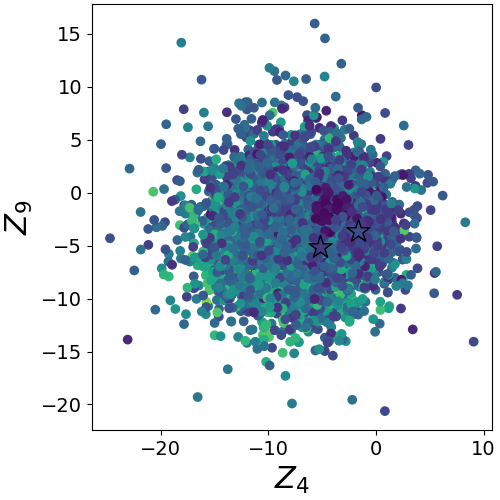

IndexError: invalid index to scalar variable.

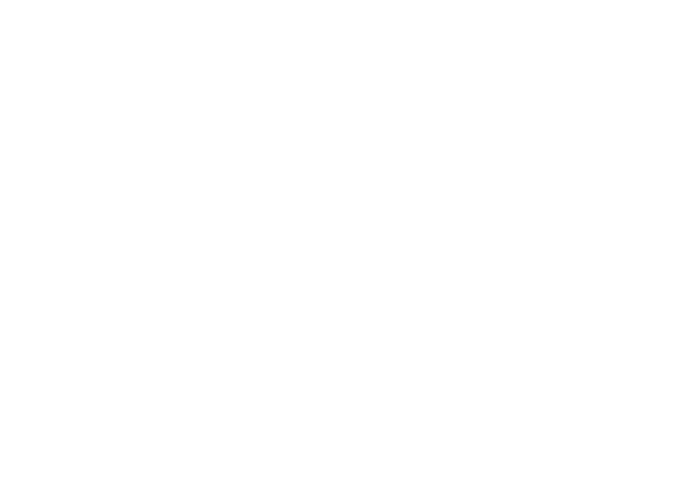

In [322]:
plt.close('all')

fig = plt.figure(figsize=(5, 5), constrained_layout=True)
plt.scatter(z_mach[:, 4], z_mach[:, -1], c=norm(neseps))
plt.scatter(z_mach[sample_1, 4], z_mach[sample_1, -1], c=neseps[sample_1], marker='*', s=300, cmap=cmap, norm=norm, edgecolor=(0, 0, 0))
plt.scatter(z_mach[sample_2, 4], z_mach[sample_2, -1], c=neseps[sample_2], marker='*', s=300, cmap=cmap, norm=norm, edgecolor=(0, 0, 0))
plt.xlabel('$Z_4$')
plt.ylabel('$Z_9$')
plt.show()

"""
fig, ax = plt.subplots(figsize=(6, 1), dpi=400)
fig.subplots_adjust(bottom=0.8)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax, orientation='horizontal', label='$n_{e, sep}$ [m$^-3$]')
plt.show()
"""
fig = plt.figure(figsize=(7, 5), constrained_layout=True)
plt.scatter(rmids[sample_1][masks[sample_1] > 0], profs_real[sample_1][0][masks[sample_1] > 0 ], c=[neseps[sample_1]]*(masks[sample_1] > 0).sum(), cmap=cmap, norm=norm)
plt.plot(rmids[sample_1][masks[sample_1] > 0], mean_prof_sample_1[0][masks[sample_1] > 0 ], color=cmap(norm(neseps[sample_1])))
plt.errorbar(rmids[sample_1][masks[sample_1] > 0], mean_prof_sample_1[0][masks[sample_1] > 0 ], yerr=std_prof_sample_1[0][masks[sample_1] > 0 ] , alpha=0.5, color=cmap(norm(neseps[sample_1])))

plt.scatter(rmids[sample_2][masks[sample_2] > 0], profs_real[sample_2][0][masks[sample_2] > 0 ], c=[neseps[sample_2]]*(masks[sample_2] > 0).sum(), cmap=cmap, norm=norm)
plt.plot(rmids[sample_2][masks[sample_2] > 0], mean_prof_sample_2[0][masks[sample_2] > 0 ], color=cmap(norm(neseps[sample_2])))
plt.errorbar(rmids[sample_2][masks[sample_2] > 0], mean_prof_sample_2[0][masks[sample_2] > 0 ], yerr=std_prof_sample_2[0][masks[sample_2] > 0 ] , alpha=0.5, color=cmap(norm(neseps[sample_2])))

plt.show()